## Using Differential Privacy for Privacy-preserving Statistical Releases on Synthetic Suvery Data

![title](images/researchers.jpeg)

This notebook is aimed at demonstrating how to generate and release basic statistical outcomes in differentially private manner. 

Let's assume NRF has requested A\*STAR for the following statistics (queries): 
- Count of researchers 
- Sum of researchers' salary 
- Mean of researchers' salary 
- Count of researchers by sector
- Count of researchers by sector and academic degree


In this notebook we will limit to **Laplacian Mechanism**, and study the impact of the following:  
1. **Epsilon(ε)**: The privacy loss incurred by researchers in the dataset. Larger values indicate less privacy and more accuracy.
2. **Sensitivity**: The worst case change in a query's output when a row is removed/added. Noise scales with the sensitivity of a query.
3. **Clamping bounds**: Clipping the raw values to the set lower and upper bounds. Noise scales with the size of the bounds
4. **Dataset size**: Noise cancels out with larger dataset size. 

With the above queries we will also be introduced to the concepts of **parallel composition** and **post-processing**.  

### Contents 

1. [Differential Private Mechanisms](#cell1)
    * 1.1. [Visualising laplacian distribution ](#cell11)
    * 1.2. [Visualising the impact of epsilon on noise scale](#cell12)

### Imports 

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

### Differential Private Mechanisms <a id="cell1"></a>

## Laplace Mechanism 

For a function ${f}(x)$ that output's a number for a query, **laplace mechanism** $M(x)$ is given as: 

$M(x)= {f}(x) + Lap(\frac{s}{\epsilon}$)

where **$s$** denotes sensitivtity and **$Lap(S)$** denotes sampling a random value from the [laplacian distribution](https://en.wikipedia.org/wiki/Laplace_distribution) with center 0 and scale **$S$** = $\frac{sensitivity}{epsilon}$.

You can notice that the noise scale is directly proportional to sensitivity ($s$) and inversely proportional to epsilon ($\epsilon$).

The laplacian mechanism satisfies the **$\epsilon$-differential privacy** i.e. pure-differential privacy, meaning, it provides worst case privacy gaurantee to the individuals in the dataset. 

In [2]:
def laplace_mechanism(query, sensitivity, epsilon):
    return query + np.random.laplace(loc=0, scale=sensitivity/epsilon)

#### Gaussian Mechanism 

For a function ${f}(x)$ that output's a number for a query, **gaussian mechanism** $M(x)$ is given as: 

$M(x)= {f}(x) + \mathcal{N}(\sigma^{2})$

where $\sigma^{2} = \frac{2s^2 \log(1.25/\delta)}{\epsilon^2}$

$\mathcal{N}(\sigma^{2})$ denotes sampling a random value from the [gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) with center 0 and scale **$\sigma^{2}$**. 

$s$ is sensitivity  

𝛿 is the failue probability 
- With probability 1−𝛿, we will get the same guarantee as pure differential privacy;
- with probability 𝛿, we get no guarantee 

You can notice that the noise scale is directly proportional to sensitivity ($s$) and inversely proportional to epsilon ($\epsilon$) and delta ($\delta$).

The gaussian mechanism satisfies the **$(\epsilon, \delta)$-differential privacy** i.e. approximate-differential privacy, meaning, it provides relaxed privacy gaurantee. 

In [3]:
def gaussian_mechanism(query, sensitivity, epsilon, delta):
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon
    return query + np.random.normal(loc=0, scale=sigma)

### Utility Functions

In [4]:
# function we will use to compute percentage absolute error 
def percentage_error(true_value, private_value):
    return round(abs(true_value - private_value)/true_value*100, 2)

In [5]:
# constants for the visualisations 
COLOR_1 = "#4CB7A5"
COLOR_2 = "#0198E1"
COLOR_3 = "#DE3163"
COLOR_MAP = "Wistia"

# function we will use to visualise the impact of sensitivity, epsilon, bounds and dataset size 
# on the accuracy of a query output
def visualise(dp_results, epsilons, errors, ylabel, title, labels, figsize=(10, 6)):
    dp_results = pd.DataFrame(dp_results, index=labels)
    
    legend_labels = ['True value']
    for epsilon, error in zip(epsilons, errors):
        legend_labels.append('ε = ' + str(epsilon) + ' : Error = ' + str(round(error, 1)) + '%')

    ax = dp_results.plot.bar(rot=0, figsize=figsize, width=0.8, fontsize=12, colormap = COLOR_MAP)
    
    plt.title(title, fontsize=16)
    plt.grid(axis='y', alpha=0.5)
    plt.ylabel(ylabel, fontsize = 14)
    plt.legend(fontsize = 12, labels=legend_labels)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Calulating Queries on Researchers Survey Data

#### Loading the Survey Data

In [6]:
# reading the csv file 
data = pd.read_csv("data/simulated_data_500.csv")
data_size = len(data)

print(f"Number of rows in the dataset {data_size}")
data.head(20)

Number of rows in the dataset 500


,NRIC,researcher_name,sector,salary,degree
0,G5629588W,Justin Smith,Healthcare,7632,Masters
1,S6111665R,Milton Dunn,Agricultural,13832,Post-grad
2,S9246827E,Edmund Volante,Agricultural,9010,PhD
3,T3962425J,Vicki Mcalpine,Aerospace,12823,Non-degree
4,T2736605S,John Walker,Aerospace,14431,Bachelors
5,F6320719Z,Connie Thomson,Agricultural,6549,Post-grad
6,G1978827T,Anna Reynolds,Healthcare,10554,Post-grad
7,S3962825E,Clare Riley,Agricultural,5626,Non-degree
8,T5219183N,Carmen Willey,Healthcare,10891,Masters
9,F2074020T,Edgar Lopez,Engineering,11768,Bachelors


#### 1. Counting the number of researchers 

##### True count

In [7]:
true_count = len(data['researcher_name'])
print(f"True count of the researchers: {true_count}")

True count of the researchers: 500


##### Private count 

As a rule of thumb, sensitivity of **count** query is 1. 

In [8]:
sensitivity = 1 
epsilon = 0.1

private_count = laplace_mechanism(true_count, sensitivity, epsilon)

print(f"Private count of the researchers: {private_count} with error: {percentage_error(true_count, private_count)}%")

Private count of the researchers: 496.3002321918458 with error: 0.74%


#### Impact of epsilon on the query's accuracy

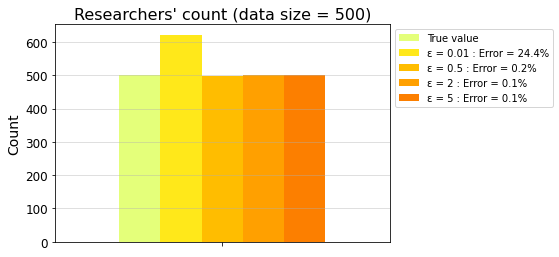

In [9]:
epsilons = [0.01, 0.5, 2, 5]
errors = []
dp_results = {}
dp_results["true_count"] = [true_count]

for epsilon in epsilons:
    private_count = laplace_mechanism(true_count, sensitivity, epsilon)
    dp_results[f"epsilon_{epsilon}"] = [private_count]
    errors.append(percentage_error(true_count, private_count))

# visualise data 
labels = [""]
title = f"Researchers' count (data size = {data_size})"
ylabel = "Count"
visualise(dp_results, epsilons, errors, ylabel, title, labels, (6, 4))

#### 2. Sum of the researchers' salary 

In [10]:
true_sum_salary = sum(data['salary'])
print(f"True sum of the researchers' salary: {true_sum_salary}")

True sum of the researchers' salary: 4623652


#### Settings the bounds 

Clamping bounds for min and max BERD contributions by a firm 
The data is clamped to be within min and max bounds in order to limit
the influence any one firm has on the query. If these bounds are too 
tight, the release may be biased, because values outside these bounds
are replaced with the nearest bound. On the other hand, if these bounds 
are too wide, the respective release will have greater variance.
   

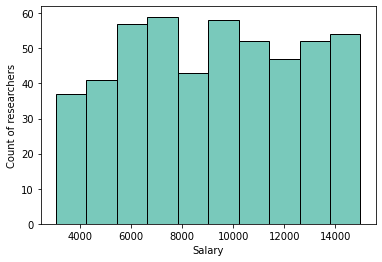

In [11]:
sns.histplot(data['salary'], color=COLOR_1)
plt.xlabel('Salary')
plt.ylabel('Count of researchers');

In [12]:
upper_bound = 6000
lower_bound = 9000
# applying clamping 
data['bounded_salary'] = data['salary'].clip(lower=lower_bound, upper=lower_bound)

In [13]:
sensitivity = upper_bound 
epsilon = 0.1

private_sum_salary = laplace_mechanism(true_sum_salary, sensitivity, epsilon)

print(f"Private sum of the researchers's salary: {private_sum_salary} with error: {percentage_error(true_sum_salary, private_sum_salary)}%")

Private sum of the researchers's salary: 4587684.064070455 with error: 0.78%


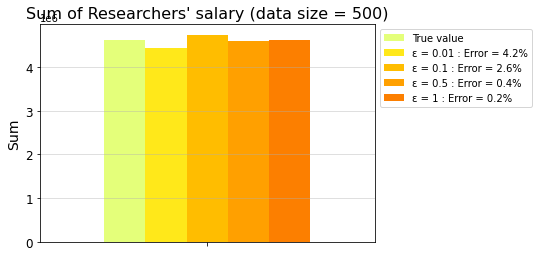

In [14]:
epsilons = [0.01, 0.1, 0.5, 1]
errors = []
dp_results = {}
dp_results["true_sum"] = [true_sum_salary]

for epsilon in epsilons:
    private_sum_salary = laplace_mechanism(true_sum_salary, sensitivity, epsilon)
    dp_results[f"epsilon_{epsilon}"] = [private_sum_salary]
    errors.append(percentage_error(true_sum_salary, private_sum_salary))

# visualise data 
labels = [""]
title = f"Sum of Researchers' salary (data size = {data_size})"
ylabel = "Sum"
visualise(dp_results, epsilons, errors, ylabel, title, labels, (6, 4))

# SHOW the impact of bounds 

#### 3. Mean of the reserachers' salary (post-processing)

In [15]:
true_mean_salary = true_sum_salary/true_count
print(f"True mean of the researchers's salary: {true_mean_salary}")

True mean of the researchers's salary: 9247.304


In [16]:
private_mean_salary = private_sum_salary/private_count
print(f"Private mean of the researchers's salary: {private_mean_salary} with error: {percentage_error(true_mean_salary, private_mean_salary)}%")

Private mean of the researchers's salary: 9248.502504112574 with error: 0.01%


## Parallel composition 

Parallel composition is based on the idea of splitting your dataset into disjoint chunks and running a differentially private mechanism on each chunk separately. Since the chunks are disjoint, each individual’s data appears in exactly one k chunk - so even if there are  chunks in total (and therefore k runs of the mechanism), the mechanism runs exactly once on the data of each individual.

#### 4. Counting the number of researchers by sector

We will assume that each researcher belongs to only one sector. 

Note: If a reseacher belongs to more than one sector than sensivity of the query will increase. Moreover, we need to apply bounds on the maximum sectors a researcher can belong to prevent scaling of the noise. 

##### **True** count of the researchers by sector

In [45]:
true_counts_by_sector = data['sector'].value_counts().to_frame()
true_counts_by_sector

,sector
Agricultural,137
Engineering,125
Aerospace,120
Healthcare,118


##### **Private** count of the researchers by sector

This analysis has a total privacy loss of the set epsilon value (in this case 1), even though we release many results

In [46]:
# sensitivity of the query is 1 
sensitivity = 1 
# setting the epsilon 
epsilon = 1

# function to add noise from the laplace distribution
add_laplace_noise = lambda true_value: laplace_mechanism(true_value, sensitivity, epsilon)
# adding noise
private_count_by_sector = data['sector'].value_counts().apply(add_laplace_noise)

private_count_by_sector.to_frame()

,sector
Agricultural,134.178402
Engineering,125.194374
Aerospace,119.992018
Healthcare,121.325059


#### Impact of epsilon on the query's output 

In [47]:
true_counts_by_sector_dict = dict(true_counts_by_sector['sector'])
# true_counts_by_sector_dict['Agricultural']
true_counts_by_sector_dict

{'Agricultural': 137, 'Engineering': 125, 'Aerospace': 120, 'Healthcare': 118}

[82.30250000000001, 5.1775, 2.4225, 1.1724999999999999]


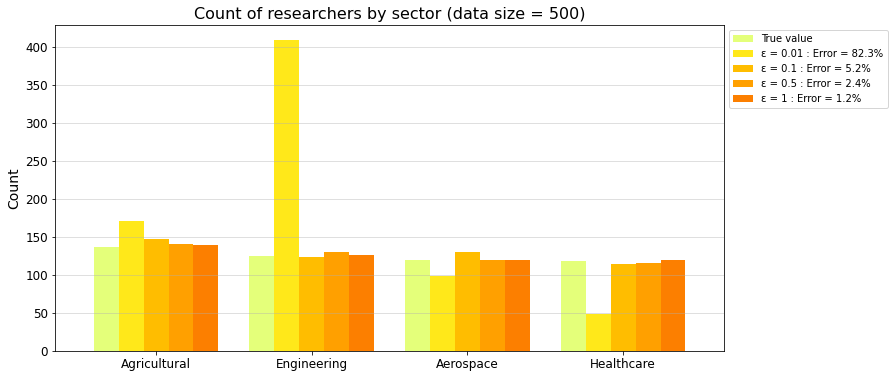

In [48]:
epsilons = [0.01, 0.1, 0.5, 1]
errors = []
dp_results = {}

true_counts_by_sector = true_counts_by_sector_dict.values()
dp_results["true_counts_by_sector"] = true_counts_by_sector
num_sectors = len(true_counts_by_sector)

for epsilon in epsilons:
    private_counts_by_sector = [laplace_mechanism(true_count, sensitivity, epsilon) for true_count in true_counts_by_sector]
    dp_results[f"epsilon_{epsilon}"] = private_counts_by_sector
    error = sum([percentage_error(tc, pc) for  tc, pc in zip(true_counts_by_sector, private_counts_by_sector)])/num_sectors
    errors.append(error)

# visualise data 
labels = true_counts_by_sector_dict.keys() #["Aerospace", "Agricultural", "Engineering", "Healthcare"]
title = f"Count of researchers by sector (data size = {data_size})"
ylabel = "Count"

print(errors)
visualise(dp_results, epsilons, errors, ylabel, title, labels, (12, 6))

#### 5. Counting the number of researchers by degree and sector

In [30]:
pd.crosstab(data['sector'], data['degree'])

degree,Bachelors,Masters,Non-degree,PhD,Post-grad
sector,,,,,
Aerospace,29,23,24,19,25
Agricultural,31,22,23,27,34
Engineering,24,30,16,32,23
Healthcare,25,20,27,22,24


In [31]:
sensitivity = 1 
epsilon = 0.5

true_count_by_degree_and_sector = pd.crosstab(data['sector'], data['degree'])
add_laplace_noise = lambda true_value: laplace_mechanism(true_value, sensitivity, epsilon)
true_count_by_degree_and_sector.applymap(add_laplace_noise)

degree,Bachelors,Masters,Non-degree,PhD,Post-grad
sector,,,,,
Aerospace,29.112717,22.987379,28.867568,18.214731,24.802709
Agricultural,33.000078,21.445613,26.751272,30.832729,38.648015
Engineering,25.777203,31.786634,19.919268,31.577088,21.179907
Healthcare,27.435232,17.044140,25.807760,17.447751,19.702181


### Impact of the dataset size 